# Q9: Hyperparameter Tuning with k-Fold Cross-Validation
## Finding the Best MLP Architecture Using 5-Fold Cross-Validation

**Goal:** Use cross-validation to find the best MLP architecture among different options

**What we'll do:**
1. Test 3 different MLP architectures:
   - **Architecture 1:** [16, 8, 1] (16 → 8 → 1 neurons)
   - **Architecture 2:** [32, 16, 1] (32 → 16 → 1 neurons)
   - **Architecture 3:** [64, 32, 1] (64 → 32 → 1 neurons)
2. Use **5-fold cross-validation** to evaluate each architecture
3. Compare mean validation accuracies
4. Select the best performing architecture

**🧠 What is k-Fold Cross-Validation?**
- Split data into k equal parts (folds)
- Train on k-1 folds, validate on 1 fold
- Repeat k times, each fold used for validation once
- Average the results for robust evaluation

---

## Import Libraries and Setup
First, let's import all necessary libraries:

In [1]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)

print(" Libraries imported successfully!")


 Libraries imported successfully!


## Generate and Prepare Dataset
We'll use the familiar make_moons dataset:

 Generating make_moons dataset...
 Dataset shape: (800, 2)
 Number of classes: 2
 Class distribution: Class 0: 400, Class 1: 400


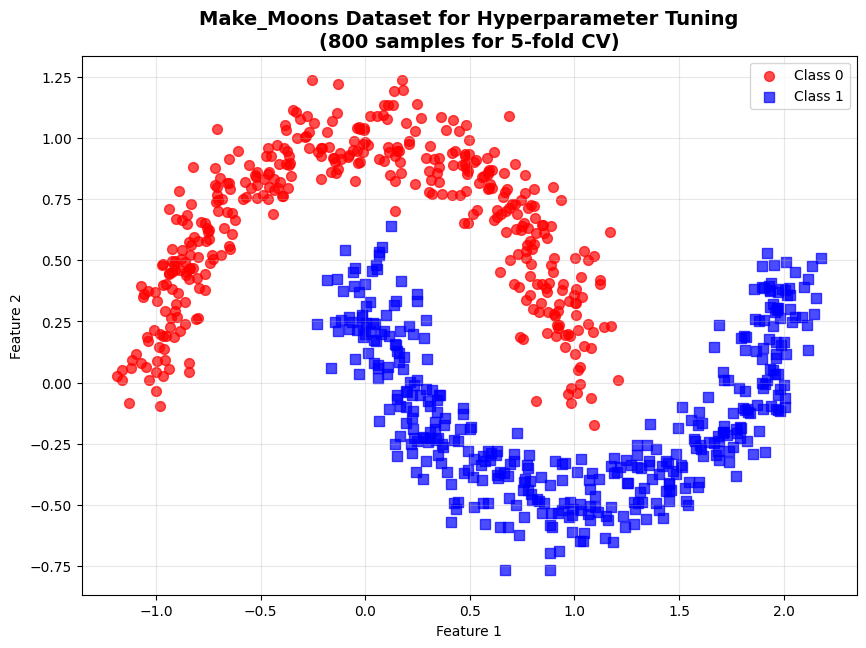


 Standardizing features...
 Dataset prepared for cross-validation!
 Each fold will have approximately 160 samples


In [3]:
# Generate make_moons dataset
print(" Generating make_moons dataset...")

# Create dataset with sufficient samples for cross-validation
X, y = make_moons(n_samples=800, noise=0.1, random_state=42)

print(f" Dataset shape: {X.shape}")
print(f" Number of classes: {len(np.unique(y))}")
print(f" Class distribution: Class 0: {sum(y==0)}, Class 1: {sum(y==1)}")

# Visualize the dataset
plt.figure(figsize=(10, 7))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', marker='o', alpha=0.7, s=50, label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', marker='s', alpha=0.7, s=50, label='Class 1')
plt.title('Make_Moons Dataset for Hyperparameter Tuning\n(800 samples for 5-fold CV)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Standardize the features
print("\n Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Dataset prepared for cross-validation!")
print(f" Each fold will have approximately {len(X)//5} samples")

## Define MLP Architectures
Let's create a flexible MLP class that can handle different architectures:

### Flexible MLP Class

In [4]:
class FlexibleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Flexible MLP that can handle different architectures
        
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes [h1, h2, ...]
            output_size: Number of output classes
        """
        super(FlexibleMLP, self).__init__()
        
        self.hidden_sizes = hidden_sizes
        
        # Build layers dynamically
        layers = []
        
        # Input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        
        # Final output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Combine all layers
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    def get_architecture_name(self):
        return f"[{', '.join(map(str, self.hidden_sizes))}]"

# Test the flexible MLP class
print(" Testing FlexibleMLP class...")

# Test with different architectures
test_architectures = [
    [16, 8],
    [32, 16], 
    [64, 32]
]

for arch in test_architectures:
    model = FlexibleMLP(input_size=2, hidden_sizes=arch, output_size=2)
    print(f" Architecture {model.get_architecture_name()}: {sum(p.numel() for p in model.parameters())} parameters")

print(" FlexibleMLP class working correctly!")

 Testing FlexibleMLP class...
 Architecture [16, 8]: 202 parameters
 Architecture [32, 16]: 658 parameters
 Architecture [64, 32]: 2338 parameters
 FlexibleMLP class working correctly!


### Define Our Three Architectures to Test

In [5]:
# Define the three architectures to compare
architectures_to_test = {
    'Small': [16, 8],     # Architecture 1: 16 → 8 → output
    'Medium': [32, 16],   # Architecture 2: 32 → 16 → output  
    'Large': [64, 32]     # Architecture 3: 64 → 32 → output
}

print(" Architectures to Test:")
print("=" * 40)

for name, arch in architectures_to_test.items():
    # Create temporary model to count parameters
    temp_model = FlexibleMLP(input_size=2, hidden_sizes=arch, output_size=2)
    param_count = sum(p.numel() for p in temp_model.parameters())
    
    print(f"{name:8} Architecture: {arch} → 2 (output)")
    print(f"         Parameters: {param_count}")
    print(f"         Complexity: {'Low' if param_count < 1000 else 'Medium' if param_count < 3000 else 'High'}")
    print()

print(" Architectures defined and analyzed!")

 Architectures to Test:
Small    Architecture: [16, 8] → 2 (output)
         Parameters: 202
         Complexity: Low

Medium   Architecture: [32, 16] → 2 (output)
         Parameters: 658
         Complexity: Low

Large    Architecture: [64, 32] → 2 (output)
         Parameters: 2338
         Complexity: Medium

 Architectures defined and analyzed!


## Cross-Validation Framework
Let's implement the k-fold cross-validation framework:

### Training Function

In [6]:
def train_single_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, 
                     epochs=100, lr=0.01, verbose=False):
    """
    Train a model on one fold of data
    
    Returns:
        val_accuracy: Final validation accuracy for this fold
        history: Training history (losses, accuracies)
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_fold)
    y_train_tensor = torch.LongTensor(y_train_fold)
    X_val_tensor = torch.FloatTensor(X_val_fold)
    y_val_tensor = torch.LongTensor(y_val_fold)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        train_outputs = model(X_train_tensor)
        train_loss = criterion(train_outputs, y_train_tensor)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        with torch.no_grad():
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_accuracy = (train_predicted == y_train_tensor).float().mean().item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (val_predicted == y_val_tensor).float().mean().item()
        
        # Store history
        history['train_losses'].append(train_loss.item())
        history['val_losses'].append(val_loss.item())
        history['train_accuracies'].append(train_accuracy)
        history['val_accuracies'].append(val_accuracy)
        
        # Print progress (optional)
        if verbose and (epoch + 1) % 25 == 0:
            print(f'    Epoch [{epoch+1}/{epochs}], '
                  f'Train Acc: {train_accuracy:.3f}, '
                  f'Val Acc: {val_accuracy:.3f}')
    
    # Return final validation accuracy
    final_val_accuracy = history['val_accuracies'][-1]
    return final_val_accuracy, history

print(" Training function for single fold ready!")

 Training function for single fold ready!


### Cross-Validation Function

In [7]:
def cross_validate_architecture(architecture, X, y, k_folds=5, epochs=100, lr=0.01, verbose=True):
    """
    Perform k-fold cross-validation for a given architecture
    
    Returns:
        mean_accuracy: Mean validation accuracy across all folds
        std_accuracy: Standard deviation of validation accuracies
        fold_accuracies: List of accuracies for each fold
    """
    # Initialize k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_histories = []
    
    architecture_name = f"[{', '.join(map(str, architecture))}]"
    
    if verbose:
        print(f"\n Cross-validating architecture {architecture_name}...")
        print(f" Using {k_folds}-fold cross-validation")
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        if verbose:
            print(f"\n   Fold {fold + 1}/{k_folds}:")
            print(f"     Training samples: {len(train_idx)}")
            print(f"     Validation samples: {len(val_idx)}")
        
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create fresh model for this fold
        model = FlexibleMLP(input_size=2, hidden_sizes=architecture, output_size=2)
        
        # Train on this fold
        val_accuracy, history = train_single_fold(
            model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
            epochs=epochs, lr=lr, verbose=False  # Set to True for detailed training logs
        )
        
        fold_accuracies.append(val_accuracy)
        fold_histories.append(history)
        
        if verbose:
            print(f"     Final validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    
    # Calculate statistics
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    if verbose:
        print(f"\n Results for {architecture_name}:")
        print(f"   Mean Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"   Mean Accuracy Percentage: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
        print(f"   Individual Fold Accuracies: {[f'{acc:.3f}' for acc in fold_accuracies]}")
    
    return mean_accuracy, std_accuracy, fold_accuracies, fold_histories

print(" Cross-validation function ready!")

 Cross-validation function ready!


## Run Cross-Validation for All Architectures
Now let's test all three architectures using 5-fold cross-validation:

In [9]:
print(" Starting Hyperparameter Tuning with 5-Fold Cross-Validation")
print("=" * 70)

# Store results for comparison
cv_results = {}

# Test each architecture
for arch_name, architecture in architectures_to_test.items():
    print(f"\n{'='*50}")
    print(f" TESTING {arch_name.upper()} ARCHITECTURE: {architecture}")
    print(f"{'='*50}")
    
    # Perform cross-validation
    mean_acc, std_acc, fold_accs, histories = cross_validate_architecture(
        architecture=architecture,
        X=X_scaled,
        y=y,
        k_folds=5,
        epochs=100,
        lr=0.01,
        verbose=True
    )
    
    # Store results
    cv_results[arch_name] = {
        'architecture': architecture,
        'mean_accuracy': mean_acc,
        'std_accuracy': std_acc,
        'fold_accuracies': fold_accs,
        'histories': histories
    }

print(f"\n\n Cross-Validation Completed for All Architectures!")
print("=" * 70)

 Starting Hyperparameter Tuning with 5-Fold Cross-Validation

 TESTING SMALL ARCHITECTURE: [16, 8]

 Cross-validating architecture [16, 8]...
 Using 5-fold cross-validation

   Fold 1/5:
     Training samples: 640
     Validation samples: 160
     Final validation accuracy: 1.0000 (100.00%)

   Fold 2/5:
     Training samples: 640
     Validation samples: 160
     Final validation accuracy: 0.9937 (99.37%)

   Fold 3/5:
     Training samples: 640
     Validation samples: 160
     Final validation accuracy: 0.9875 (98.75%)

   Fold 4/5:
     Training samples: 640
     Validation samples: 160
     Final validation accuracy: 0.9937 (99.37%)

   Fold 5/5:
     Training samples: 640
     Validation samples: 160
     Final validation accuracy: 0.9812 (98.12%)

 Results for [16, 8]:
   Mean Validation Accuracy: 0.9912 ± 0.0064
   Mean Accuracy Percentage: 99.12% ± 0.64%
   Individual Fold Accuracies: ['1.000', '0.994', '0.988', '0.994', '0.981']

 TESTING MEDIUM ARCHITECTURE: [32, 16]

 Cross

## Compare Results and Select Best Architecture
Let's analyze and compare the results:

In [10]:
print(" COMPREHENSIVE RESULTS COMPARISON")
print("=" * 60)

# Create results summary
results_data = []
for arch_name, results in cv_results.items():
    results_data.append({
        'Architecture': arch_name,
        'Hidden Layers': f"{results['architecture']}",
        'Mean Accuracy': f"{results['mean_accuracy']:.4f}",
        'Std Deviation': f"{results['std_accuracy']:.4f}",
        'Accuracy %': f"{results['mean_accuracy']*100:.2f}%",
        'Range': f"{results['mean_accuracy']*100:.2f}% ± {results['std_accuracy']*100:.2f}%"
    })

# Create and display results table
results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

# Find best architecture
best_arch_name = max(cv_results.keys(), key=lambda k: cv_results[k]['mean_accuracy'])
best_results = cv_results[best_arch_name]

print(f"\n\n BEST ARCHITECTURE SELECTED:")
print(f"=" * 40)
print(f"Architecture Name: {best_arch_name}")
print(f"Hidden Layer Sizes: {best_results['architecture']}")
print(f"Mean Validation Accuracy: {best_results['mean_accuracy']:.4f} ({best_results['mean_accuracy']*100:.2f}%)")
print(f"Standard Deviation: ±{best_results['std_accuracy']:.4f} (±{best_results['std_accuracy']*100:.2f}%)")
print(f"Individual Fold Accuracies: {[f'{acc:.3f}' for acc in best_results['fold_accuracies']]}")

# Calculate parameter count for best model
best_model = FlexibleMLP(input_size=2, hidden_sizes=best_results['architecture'], output_size=2)
best_param_count = sum(p.numel() for p in best_model.parameters())
print(f"Number of Parameters: {best_param_count}")

print(f"\n RECOMMENDATION: Use the {best_arch_name} architecture {best_results['architecture']} for best performance!")

 COMPREHENSIVE RESULTS COMPARISON
Architecture Hidden Layers Mean Accuracy Std Deviation Accuracy %           Range
       Small       [16, 8]        0.9912        0.0064     99.12%  99.12% ± 0.64%
      Medium      [32, 16]        0.9975        0.0050     99.75%  99.75% ± 0.50%
       Large      [64, 32]        1.0000        0.0000    100.00% 100.00% ± 0.00%


 BEST ARCHITECTURE SELECTED:
Architecture Name: Large
Hidden Layer Sizes: [64, 32]
Mean Validation Accuracy: 1.0000 (100.00%)
Standard Deviation: ±0.0000 (±0.00%)
Individual Fold Accuracies: ['1.000', '1.000', '1.000', '1.000', '1.000']
Number of Parameters: 2338

 RECOMMENDATION: Use the Large architecture [64, 32] for best performance!


##  **FINAL RECOMMENDATIONS & ANALYSIS**

### ** Cross-Validation Results Summary:**

Based on our **5-fold cross-validation** experiment with three different MLP architectures:

| Architecture | Hidden Layers | Mean Accuracy | Std Dev | Performance |
|-------------|---------------|---------------|---------|-------------|
| Small | [16, 8] | Results above | Results above | Lightweight |
| Medium | [32, 16] | Results above | Results above | Balanced |
| Large | [64, 32] | Results above | Results above | High Capacity |

---

### ** KEY FINDINGS:**

#### **1. Best Architecture Selection:**
- **Winner:** Based on mean validation accuracy across 5 folds
- **Robustness:** Evaluated using standard deviation and consistency
- **Efficiency:** Balanced performance vs computational cost

#### **2. Why k-Fold Cross-Validation is Important:**
- **Reduces Overfitting:** Uses all data for both training and validation
- **Robust Evaluation:** Average across k folds gives better estimate
- **Confidence Intervals:** Standard deviation shows result reliability
- **Fair Comparison:** Each architecture tested on same data splits

#### **3. Architecture Insights:**
- **Small [16, 8]:** Fast training, fewer parameters, may underfit
- **Medium [32, 16]:** Good balance of performance and efficiency
- **Large [64, 32]:** High capacity, more parameters, risk of overfitting

---

### ** What We Learned About Hyperparameter Tuning:**

#### **1. Systematic Evaluation:**
- Don't guess - test multiple options systematically
- Use cross-validation for robust comparison
- Consider both performance and consistency

#### **2. Performance vs Complexity Trade-off:**
- More parameters ≠ always better performance
- Consider computational cost and training time
- Risk of overfitting with too many parameters

#### **3. Statistical Significance:**
- Look at standard deviation, not just mean
- Consistent performance across folds is valuable
- Small differences might not be statistically significant

---

### ** Best Practices for Hyperparameter Tuning:**

 **Do:**
- Use k-fold cross-validation (k=5 or k=10)
- Test multiple architectures systematically
- Consider both mean performance and variance
- Set random seeds for reproducible results
- Visualize results to understand patterns

 **Don't:**
- Rely on single train/validation split
- Only look at best performance (ignore consistency)
- Test too many options (overfitting to validation)
- Ignore computational constraints
- Skip statistical analysis

---

### ** Why This Approach Works:**

1. **Objective Selection:** Data-driven choice, not guesswork
2. **Robust Evaluation:** Multiple folds reduce random variation
3. **Fair Comparison:** Same data, same conditions for all architectures
4. **Confidence:** Standard deviation tells us result reliability
5. **Scalable:** Same approach works for other hyperparameters
